## **MANSI KAKKAR (EE21S063)**

# **PROGRAMMING ASSIGNMENT 4 OF DEEP LEARNING FOR IMAGING (EE5179)**

___
___

# **Autoencoders**



## Libraries Used

In [64]:
import sys
import numpy as np
import os
import matplotlib.pyplot as plt
import torch
import random
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision.utils import make_grid
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error as mse 
from PIL import Image

torch.manual_seed(2111)

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 10.0) # set default size of plots

## Setting up device

In [2]:
#Setting the device to GPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


## Initialisation

In [3]:
batch_size = 500
data_ind  = [1000, 6, 375, 789, 150, 771, 4150, 6115, 300, 8141]
epochs = 10



## Loading the data

In [4]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,)),])
dataset = datasets.MNIST(root = "data/", train = True, transform = transform, download = True)
test_dataset = datasets.MNIST(root = "data/", train = False, transform = transform, download = True)

#Splitting the Training dataset
train_dataset, validation_dataset = train_test_split(dataset, test_size=10000, train_size = 50000, random_state = None, shuffle = True)

print(f"number of train samples: {len(train_dataset)}")
print(f"number of validation samples: {len(validation_dataset)}")
print(f"number of test samples: {len(test_dataset)}")

train_loader = DataLoader(train_dataset, batch_size = batch_size)
validation_loader = DataLoader(validation_dataset, batch_size = batch_size)
test_loader = DataLoader(test_dataset, batch_size = batch_size)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw

number of train samples: 50000
number of validation samples: 10000
number of test samples: 10000


In [5]:
print(f"size of train dataloader is :{len(train_loader)}")
print(f"size of validation dataloader is :{len(validation_loader)}")
print(f"size of test dataloader is :{len(test_loader)}")
data = next(iter(train_loader))
train_img, train_target = data
print(f"Train image shape:{train_img.shape}")
print(f"Train Targets shape:{train_target.shape}")

data = next(iter(validation_loader))
val_img, val_target = data
print(f"Validation image shape:{val_img.shape}")
print(f"Validation Targets shape:{val_target.shape}")

data = next(iter(test_loader))
test_img, test_target = data
print(f"Test image shape:{test_img.shape}")
print(f"Test Targets shape:{test_target.shape}")

size of train dataloader is :100
size of validation dataloader is :20
size of test dataloader is :20
Train image shape:torch.Size([500, 1, 28, 28])
Train Targets shape:torch.Size([500])
Validation image shape:torch.Size([500, 1, 28, 28])
Validation Targets shape:torch.Size([500])
Test image shape:torch.Size([500, 1, 28, 28])
Test Targets shape:torch.Size([500])


# **1. Comparing PCA and Autoencoders**

## PCA

In [6]:
def visualise_data(data, data_ind = data_ind):
  fig, ax = plt.subplots(1, 10, figsize = (20,20))
  for i,ind in enumerate(data_ind):
    image_sample = np.asarray(data[ind],dtype = np.uint8).reshape(28,28)
    image_obj = Image.fromarray(image_sample) 
    print('for digit '+str(i))
    ax[i].imshow(image_obj)
  plt.show()

torch.Size([70000, 784])
for digit 0
for digit 1
for digit 2
for digit 3
for digit 4
for digit 5
for digit 6
for digit 7
for digit 8
for digit 9


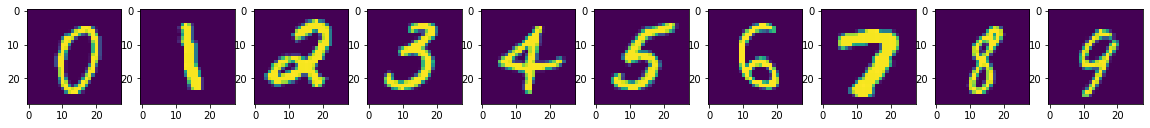

In [7]:
pca_train = (dataset.data).reshape(60000,784)
pca_test = (test_dataset.data).reshape(10000,784)
data = torch.cat((pca_train, pca_test))
print(data.shape)
visualise_data(data)


reconstruction error is : 0.018056392603431226
for digit 0
for digit 1
for digit 2
for digit 3
for digit 4
for digit 5
for digit 6
for digit 7
for digit 8
for digit 9


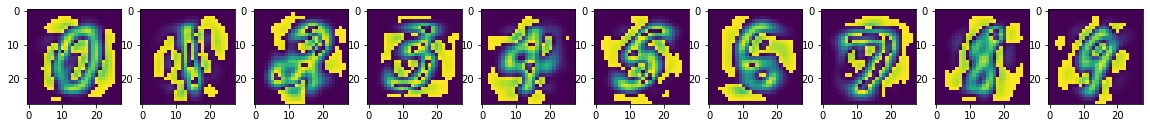

In [8]:
pca_data = data.reshape(70000, 784)
pca_data = np.asarray(pca_data)/255
pca_30 = PCA(n_components = 30)
pca_30.fit(pca_data)
train_pca = pca_30.transform(pca_data)
recover_data = pca_30.inverse_transform(train_pca)
pca_error = mse(pca_data, recover_data)
print(f'reconstruction error is : {pca_error}')

visualise_data(recover_data*255)

In [9]:
# def PCA_implementation(data, num_of_values = 30):
#   mean =  torch.mean(data.float(),0)
#   data = data - mean.expand_as(data)
#   U,S,V = torch.svd(torch.mm(data,torch.t(data)))
#   return torch.mm(data,U[:,:num_of_values]),U[:,:num_of_values]

In [10]:
# recover_data = PCA_implementation(data, 30)
#Visualisation
# for i,ind in enumerate(data_ind):
#   image_sample = np.asarray(255*recover_data[ind],dtype = np.uint8).reshape(28,28)
#   #creating image object
#   image_obj = Image.fromarray(image_sample) 
#   print('Digit '+str(i))
#   plt.imshow(image_obj)
#   plt.show()

## Training Function

In [47]:
def Train(model, optimizer, criterion, epochs = 10, sparse = False, l1_reg = 0.001, denoise = False, noise_val = 0.1, model_flag = 0):
  model.train()
  training_loss = []
  validation_loss = []
  # validation_acc = []
  for epoch in range(epochs):
    # val_correct = 0
    for i,(images, labels) in enumerate(train_loader):
      images = images.to(device)
      labels = labels.to(device)
      if(model_flag == 0):
        images = images.reshape(batch_size, 784)

      if(denoise == True):
        noisy = Add_Noise(images, noise_val) 
        output, encoded = model(noisy)
      else:
        output, encoded = model(images)
      
      t_loss = criterion(output, images)
      
      if(sparse == True):
        t_loss += l1_reg*torch.linalg.norm(encoded,1)
      
      optimizer.zero_grad()
      t_loss.backward()
      optimizer.step()
 
    training_loss.append(t_loss)
    
    for i,(images, labels) in enumerate(validation_loader):
      images = images.to(device)
      labels = labels.to(device)
      
      if(model_flag==0):
        images = images.reshape(batch_size, 784)
      
      output, encoded = model(images)
      v_loss = criterion(output, images)
      if(sparse == True):
        v_loss += l1_reg*torch.linalg.norm(encoded,1)
    validation_loss.append(v_loss)
    # validation_acc.append(val_correct/500)
  
    print('Epochs: {}/{} ||| with Training Loss = {} ||| Validation Loss = {}'.format(epoch+1, epochs, t_loss, v_loss))
  return training_loss, validation_loss


## Functions to Visualise Loss and Accuracy

In [13]:
def visualise_loss(trainingloss, valloss):
  with torch.no_grad():
    plt.figure()
    xloss=np.arange(len(trainingloss))
    plt.plot(xloss, trainingloss, color='Blue',label='Training Loss')
    plt.plot(xloss, valloss, color='Orange',label='Validation Loss')
    plt.grid(b=True, which='major', color='#666666', linestyle='-')
    plt.minorticks_on()
    plt.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
    plt.legend()
    plt.xlabel('Iterations')
    plt.ylabel(' Loss')
    plt.title(' Loss vs epochs')

def visualise_accuracy(loss_type, loss_list, accuracy):
  with torch.no_grad():
    plt.figure()
    xloss=np.arange(len(loss_list))
    plt.plot(xloss, accuracy)
    plt.grid(b=True, which='major', color='#666666', linestyle='-')
    plt.minorticks_on()
    plt.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
    plt.xlabel('Epochs')
    plt.ylabel(loss_type + 'Accuracy')
    plt.title('accuracy vs epochs')


## Function to Visualise model

In [50]:
def visualise_model(model, data_ind, data, model_flag = 0):
  with torch.no_grad():
    fig, ax = plt.subplots(1, 10, figsize = (20,20))
    for i,ind in enumerate(data_ind):
      if(model_flag==0):
        output, encoded = model(data[ind].reshape(1,784))#.cuda())
      else:
        output, encoded = model(data[ind].reshape(1, 28, 28))
      image_sample = np.asarray(output,dtype = np.uint8).reshape(28,28)   #.detach().cpu()
      image_obj = Image.fromarray(image_sample) 
      print('for digit '+str(i))
      ax[i].imshow(image_obj)
    plt.show()

## Autoencoder

In [15]:
class autoencoder(nn.Module):
  def __init__(self):
    super(autoencoder, self).__init__()
    self.encoder = nn.Sequential(nn.Linear(784, 512), nn.ReLU(), nn.Linear(512, 256), nn.ReLU(), nn.Linear(256, 128), nn.ReLU(), nn.Linear(128, 30), nn.ReLU())
    self.decoder = nn.Sequential(nn.Linear(30, 128), nn.ReLU(), nn.Linear(128, 256), nn.ReLU(), nn.Linear(256, 784), nn.ReLU())
  def forward(self, x):
    encoded = self.encoder(x.float())
    out = self.decoder(encoded)
    return out, encoded

Calling Autoencoder function

In [16]:
epochs = 15
model1 = autoencoder().to(device)
optimizer1 = optim.Adam(model1.parameters(), lr = 0.003)
criterion = nn.MSELoss()
training_loss, val_loss = Train(model1, optimizer1, criterion, epochs)


Epochs: 1/15 ||| with Training Loss = 0.6887065768241882 ||| Validation Loss = 0.6920874714851379
Epochs: 2/15 ||| with Training Loss = 0.5373498201370239 ||| Validation Loss = 0.5356813073158264
Epochs: 3/15 ||| with Training Loss = 0.483600914478302 ||| Validation Loss = 0.4819205701351166
Epochs: 4/15 ||| with Training Loss = 0.4582567811012268 ||| Validation Loss = 0.45659059286117554
Epochs: 5/15 ||| with Training Loss = 0.4338372051715851 ||| Validation Loss = 0.43202462792396545
Epochs: 6/15 ||| with Training Loss = 0.4201061725616455 ||| Validation Loss = 0.42222604155540466
Epochs: 7/15 ||| with Training Loss = 0.41564664244651794 ||| Validation Loss = 0.4123659133911133
Epochs: 8/15 ||| with Training Loss = 0.405624121427536 ||| Validation Loss = 0.4074176549911499
Epochs: 9/15 ||| with Training Loss = 0.39755842089653015 ||| Validation Loss = 0.39963024854660034
Epochs: 10/15 ||| with Training Loss = 0.3911236822605133 ||| Validation Loss = 0.3926449716091156
Epochs: 11/15 |

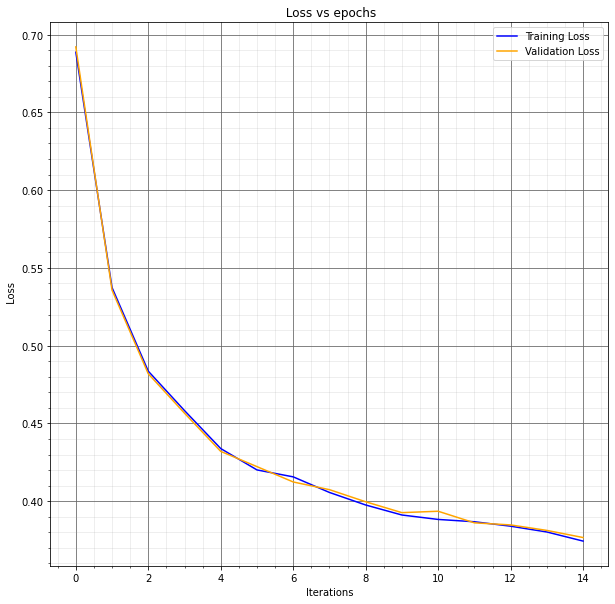

In [17]:
visualise_loss(training_loss, val_loss)

for digit 0
for digit 1
for digit 2
for digit 3
for digit 4
for digit 5
for digit 6
for digit 7
for digit 8
for digit 9


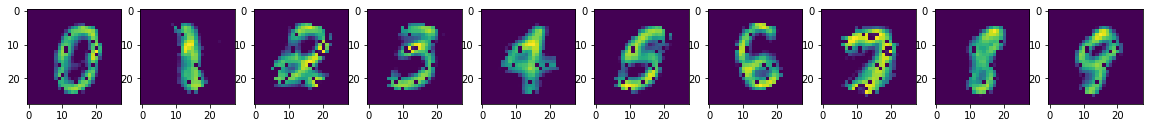

In [51]:
visualise_model(model1, data_ind, data)

**Visualise the encoded output**

torch.Size([1, 30])


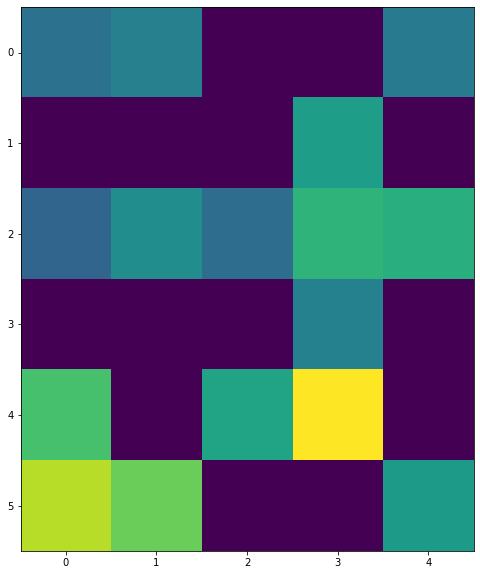

In [29]:
with torch.no_grad():
  output1, encoded1=model1.forward(data[data_ind[3]].reshape(1,784).float())
  print(encoded1.shape)
  plt.imshow(encoded1.reshape(6, 5))

## **Observations:**

* From the PCA output we can still interpret the digits but its not neatly displayed(includes a lot of noise in the signal)

* Whereas in the standard Autoencoder output, digits are more clearly visible and interpretable.

* Loss decreases to considerable amount for both training as well as validation



# **2. Experimenting with hidden units of varying sizes**

In [30]:
class autoencoder_hidden(nn.Module):
  def __init__(self, hidden_size):
    super(autoencoder_hidden, self).__init__()
    self.encoder = nn.Sequential(nn.Linear(784, hidden_size), nn.ReLU())
    self.decoder = nn.Sequential(nn.Linear(hidden_size, 784), nn.ReLU())

  def forward(self, x):
    encoded = self.encoder(x.float())
    out = self.decoder(encoded)
    return out, encoded

for Hidden Size = 64
Epochs: 1/15 ||| with Training Loss = 0.35872408747673035 ||| Validation Loss = 0.3569408357143402
Epochs: 2/15 ||| with Training Loss = 0.3178459703922272 ||| Validation Loss = 0.31832829117774963
Epochs: 3/15 ||| with Training Loss = 0.30561742186546326 ||| Validation Loss = 0.3055766224861145
Epochs: 4/15 ||| with Training Loss = 0.30175521969795227 ||| Validation Loss = 0.30178868770599365
Epochs: 5/15 ||| with Training Loss = 0.29709362983703613 ||| Validation Loss = 0.2964833974838257
Epochs: 6/15 ||| with Training Loss = 0.2916001081466675 ||| Validation Loss = 0.29153499007225037
Epochs: 7/15 ||| with Training Loss = 0.2888093888759613 ||| Validation Loss = 0.2889271080493927
Epochs: 8/15 ||| with Training Loss = 0.2881960868835449 ||| Validation Loss = 0.2883595824241638
Epochs: 9/15 ||| with Training Loss = 0.28784826397895813 ||| Validation Loss = 0.2880071997642517
Epochs: 10/15 ||| with Training Loss = 0.28757244348526 ||| Validation Loss = 0.287732273

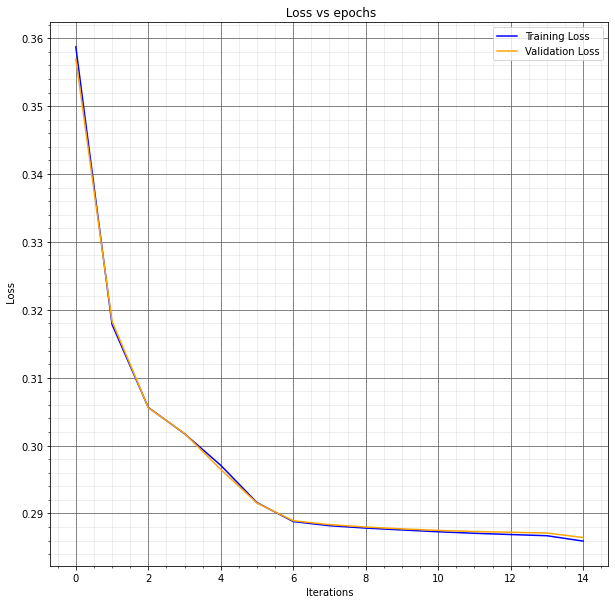

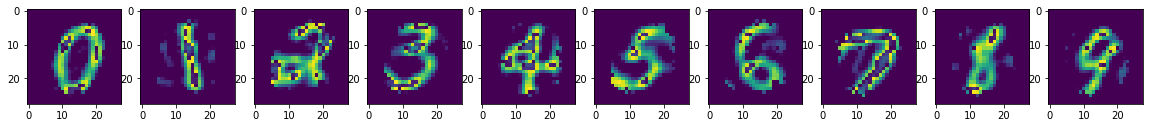

<Figure size 720x720 with 0 Axes>

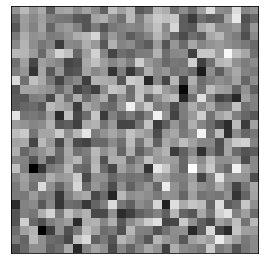

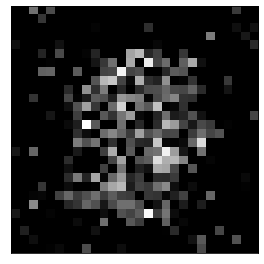

for Hidden Size = 128
Epochs: 1/15 ||| with Training Loss = 0.29094651341438293 ||| Validation Loss = 0.2902321219444275
Epochs: 2/15 ||| with Training Loss = 0.2623888850212097 ||| Validation Loss = 0.26192641258239746
Epochs: 3/15 ||| with Training Loss = 0.25273483991622925 ||| Validation Loss = 0.25269418954849243
Epochs: 4/15 ||| with Training Loss = 0.2493942528963089 ||| Validation Loss = 0.24966394901275635
Epochs: 5/15 ||| with Training Loss = 0.24694737792015076 ||| Validation Loss = 0.24729479849338531
Epochs: 6/15 ||| with Training Loss = 0.2447780966758728 ||| Validation Loss = 0.2451203614473343
Epochs: 7/15 ||| with Training Loss = 0.2436942160129547 ||| Validation Loss = 0.2442280799150467
Epochs: 8/15 ||| with Training Loss = 0.24288320541381836 ||| Validation Loss = 0.24324625730514526
Epochs: 9/15 ||| with Training Loss = 0.24240043759346008 ||| Validation Loss = 0.242728590965271
Epochs: 10/15 ||| with Training Loss = 0.24145545065402985 ||| Validation Loss = 0.2419

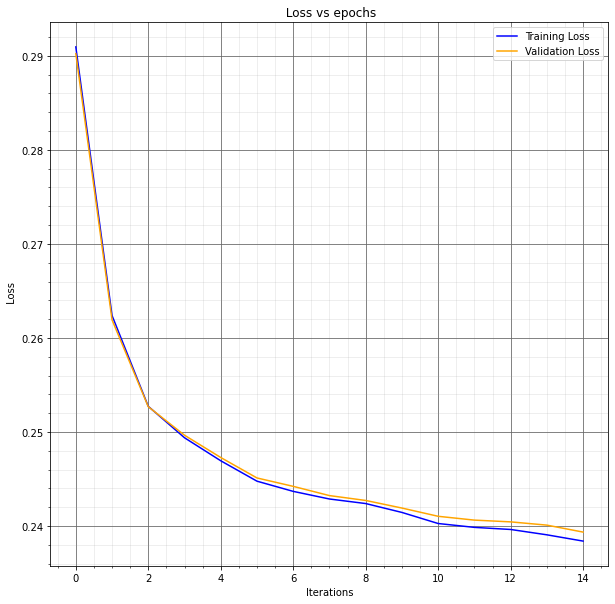

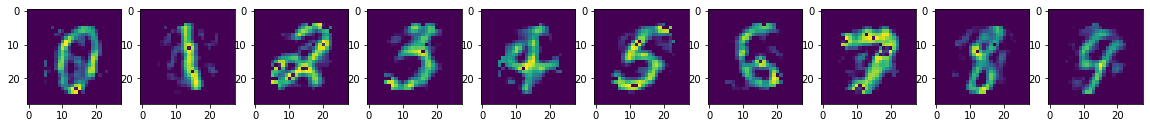

<Figure size 720x720 with 0 Axes>

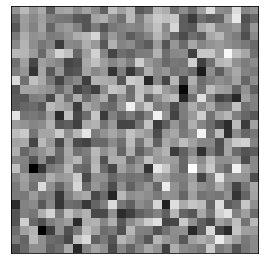

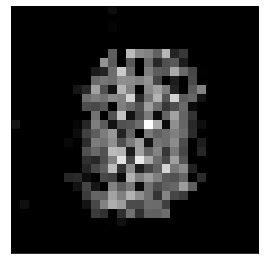

for Hidden Size = 256
Epochs: 1/15 ||| with Training Loss = 0.2579302191734314 ||| Validation Loss = 0.25769492983818054
Epochs: 2/15 ||| with Training Loss = 0.23645934462547302 ||| Validation Loss = 0.23748131096363068
Epochs: 3/15 ||| with Training Loss = 0.2301545888185501 ||| Validation Loss = 0.23136889934539795
Epochs: 4/15 ||| with Training Loss = 0.22615091502666473 ||| Validation Loss = 0.22747677564620972
Epochs: 5/15 ||| with Training Loss = 0.22367747128009796 ||| Validation Loss = 0.2248115837574005
Epochs: 6/15 ||| with Training Loss = 0.22237077355384827 ||| Validation Loss = 0.22324234247207642
Epochs: 7/15 ||| with Training Loss = 0.22127237915992737 ||| Validation Loss = 0.22221161425113678
Epochs: 8/15 ||| with Training Loss = 0.2205965220928192 ||| Validation Loss = 0.2214614748954773
Epochs: 9/15 ||| with Training Loss = 0.22031590342521667 ||| Validation Loss = 0.22110092639923096
Epochs: 10/15 ||| with Training Loss = 0.22006572782993317 ||| Validation Loss = 0.

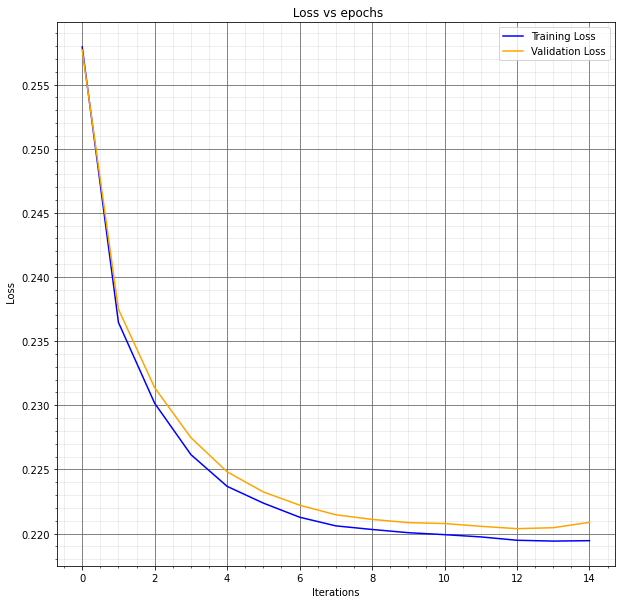

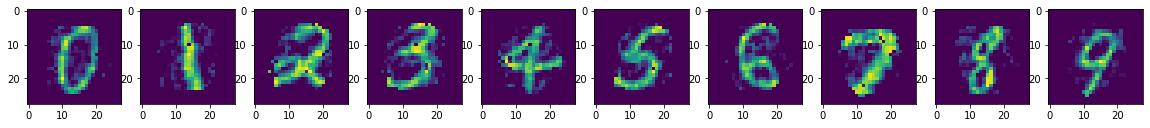

<Figure size 720x720 with 0 Axes>

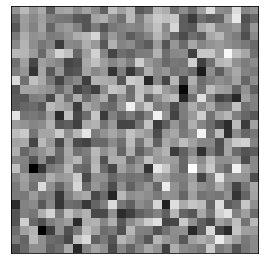

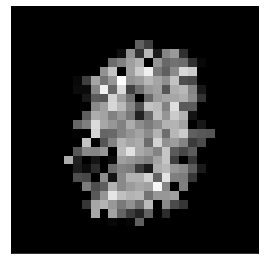

In [63]:
epochs = 15
Xnp=np.random.normal(0.5,0.05,(1,28,28))
X=torch.from_numpy(Xnp)
hidden_size = [64, 128, 256]
for i in range(3):
  print("for Hidden Size = {}".format(hidden_size[i]))
  model2 = autoencoder_hidden(hidden_size[i]).to(device)
  optimizer2 = optim.Adam(model2.parameters(), lr = 0.003)
  criterion = nn.MSELoss()
  training_loss, val_loss = Train(model2, optimizer2, criterion, epochs)
  visualise_loss(training_loss, val_loss)
  visualise_model(model2, data_ind, data)
  with torch.no_grad():
    output1=model2(X.reshape(1,784).float())
    plt.figure(1)
    fig,ax = plt.subplots()
    ax=plt.subplot(2,1,1)
    ax.set_xticks([])
    ax.set_yticks([])
    im=ax.imshow(X.detach().numpy()[0],cmap='gray')
    fig,ax = plt.subplots()
    ax=plt.subplot(2,1,2)
    ax.set_xticks([])
    ax.set_yticks([])
    im=ax.imshow(output1[0].reshape(28,28),cmap='gray')
    plt.show()

Average Hidden layer activations for 10 images for the hidden layer = 256
for the digit = 0 average value is = 44.89842224121094


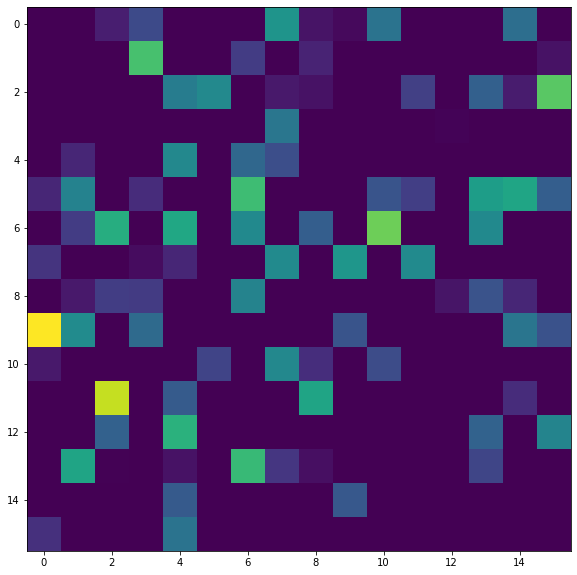

for the digit = 1 average value is = 41.207969665527344


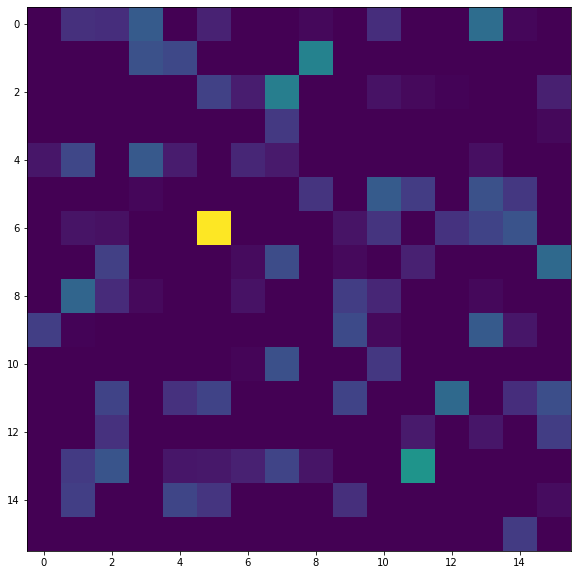

for the digit = 2 average value is = 60.484375


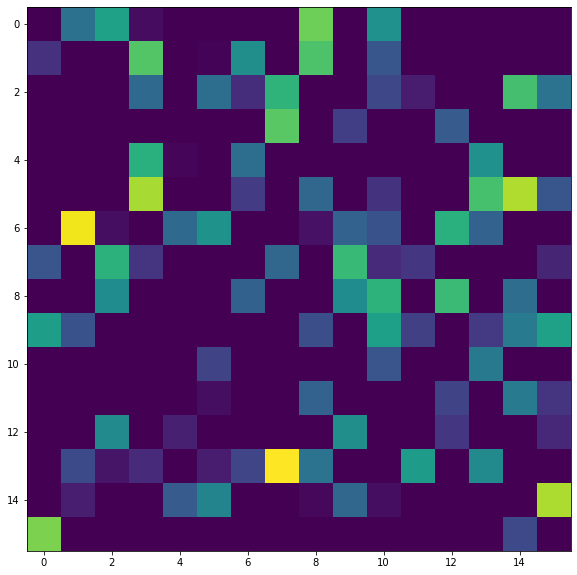

for the digit = 3 average value is = 46.20608139038086


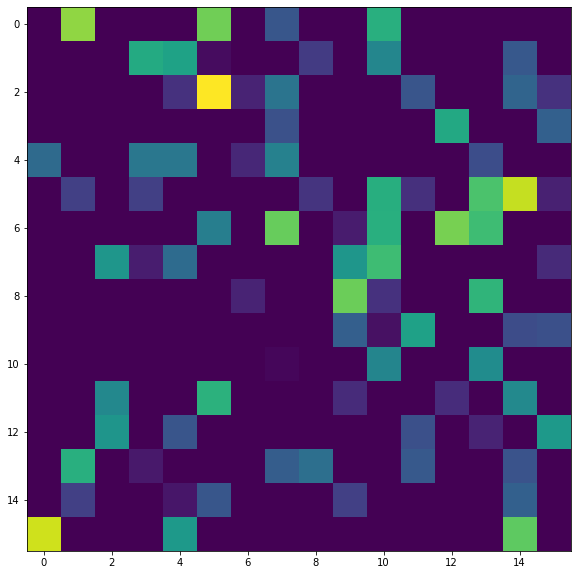

for the digit = 4 average value is = 48.670780181884766


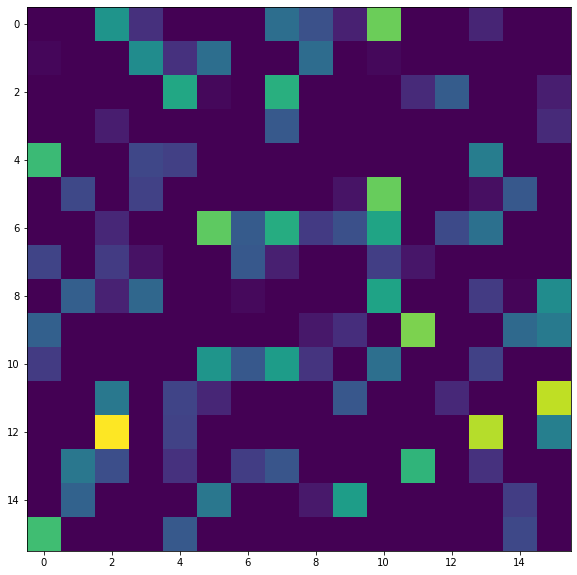

for the digit = 5 average value is = 45.45244216918945


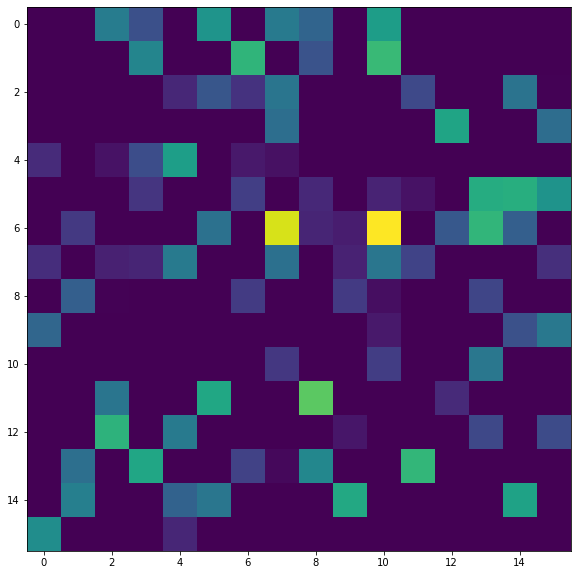

for the digit = 6 average value is = 45.25163650512695


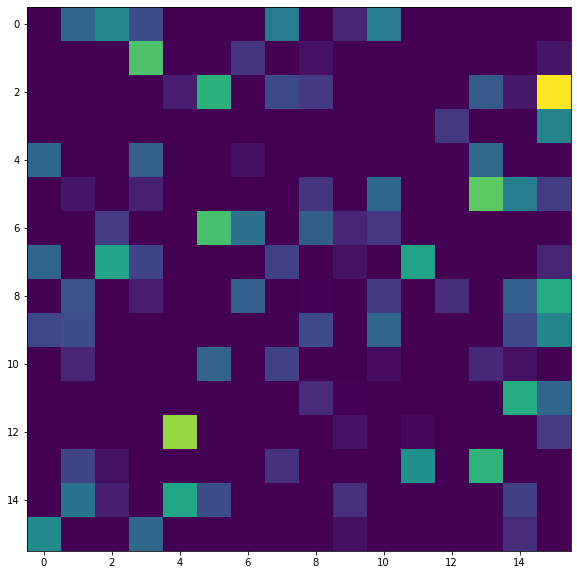

for the digit = 7 average value is = 54.53059768676758


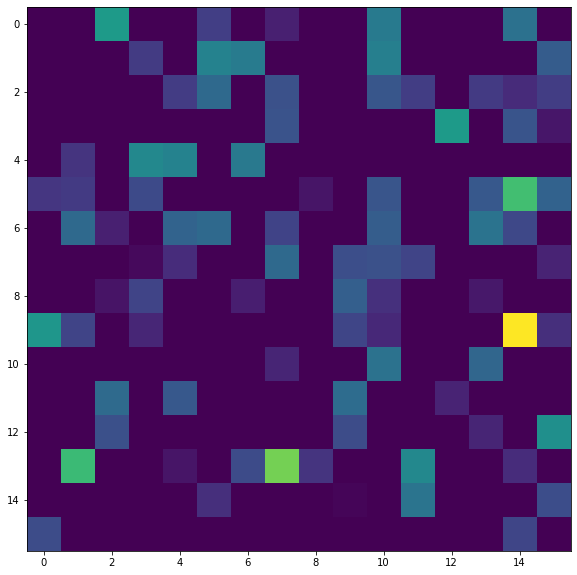

for the digit = 8 average value is = 41.96870803833008


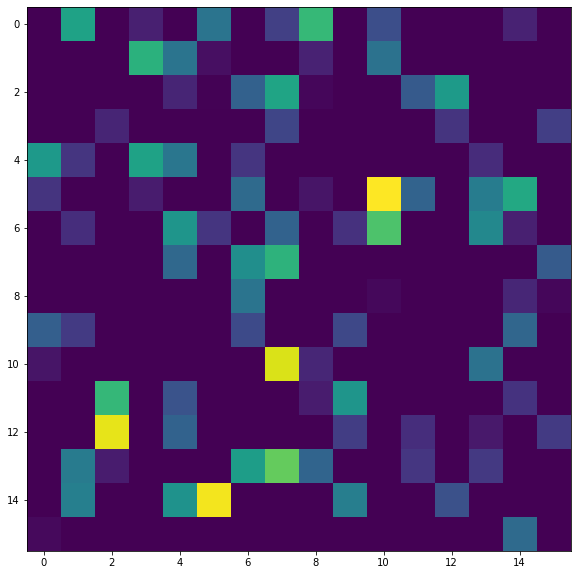

for the digit = 9 average value is = 36.63874816894531


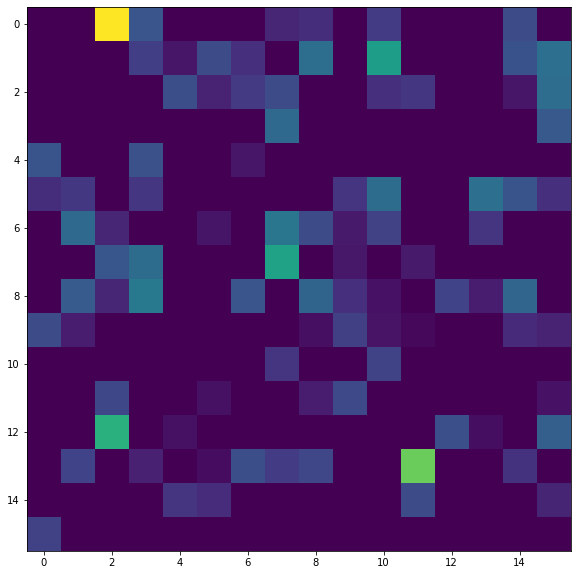

Average of these values 46.530976104736325


In [43]:
print("Average Hidden layer activations for 10 images for the hidden layer = 256")
with torch.no_grad():
  sum = 0
  for i in range(10):

    output2, encoded2=model2.forward(data[data_ind[i]].reshape(1,784).float())
    avg = torch.norm(encoded2, p=1)/256.0
    print(f'for the digit = {i} average value is = {avg.detach().numpy()}')
    sum+=avg.detach().numpy()
    plt.imshow(encoded2.reshape(16, 16))
    plt.show()
  print("Average of these values",sum/10.0)

## **Observations:**

* We can observe that for hidden layer size = 256 we get the best results as compared to the previous ones.

* We observe the best results for size = 256, by comparing both visually and by the training and validation loss obtained

# **3. Sparse Autoencoders**

In [48]:
class autoencoder_sparse(nn.Module):
  def __init__(self):
    super(autoencoder_sparse, self).__init__()
    self.encoder = nn.Sequential(nn.Linear(784, 1024), nn.ReLU())
    self.decoder = nn.Sequential(nn.Linear(1024, 784), nn.ReLU())

  def forward(self, x):
    encoded = self.encoder(x.float())
    out = self.decoder(encoded)
    return out, encoded

Epochs: 1/15 ||| with Training Loss = 0.2669614553451538 ||| Validation Loss = 0.2661038041114807
Epochs: 2/15 ||| with Training Loss = 0.2304380089044571 ||| Validation Loss = 0.23078307509422302
Epochs: 3/15 ||| with Training Loss = 0.2187575101852417 ||| Validation Loss = 0.21954764425754547
Epochs: 4/15 ||| with Training Loss = 0.21263164281845093 ||| Validation Loss = 0.21345174312591553
Epochs: 5/15 ||| with Training Loss = 0.20871004462242126 ||| Validation Loss = 0.2095082700252533
Epochs: 6/15 ||| with Training Loss = 0.20602142810821533 ||| Validation Loss = 0.20674504339694977
Epochs: 7/15 ||| with Training Loss = 0.20398883521556854 ||| Validation Loss = 0.20471002161502838
Epochs: 8/15 ||| with Training Loss = 0.20240412652492523 ||| Validation Loss = 0.20313666760921478
Epochs: 9/15 ||| with Training Loss = 0.20117852091789246 ||| Validation Loss = 0.20189400017261505
Epochs: 10/15 ||| with Training Loss = 0.20018678903579712 ||| Validation Loss = 0.2009064108133316
Epoch

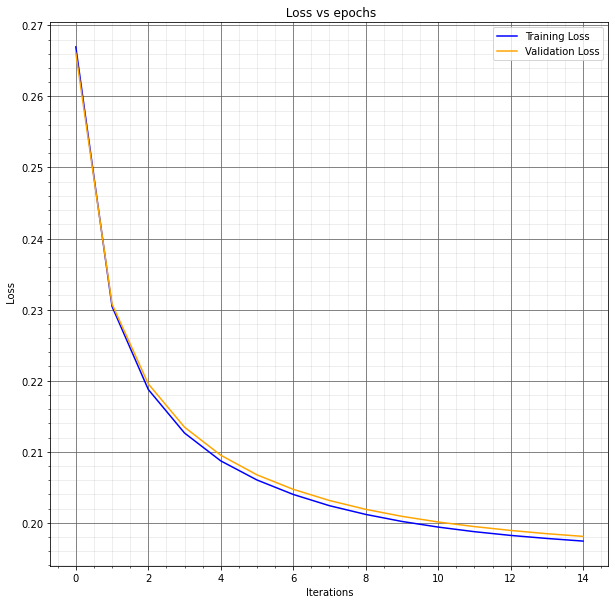

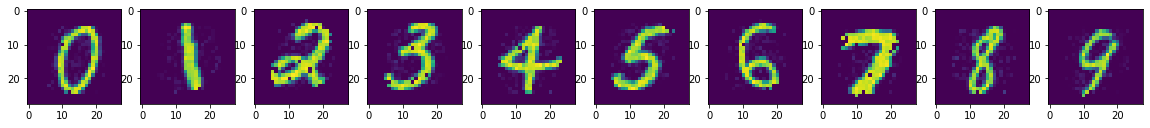

In [52]:
model3 = autoencoder_sparse().to(device)
optimizer3 = optim.Adam(model3.parameters(), lr = 0.0003)
criterion = nn.MSELoss()
training_loss, val_loss = Train(model3, optimizer3, criterion, epochs, sparse = True, l1_reg = 1e-7)
visualise_loss(training_loss, val_loss)
visualise_model(model3, data_ind, data)  


Average Hidden layer activations for 10 images for the hidden layer = 256
for the digit = 0 average value is = 76.5195083618164


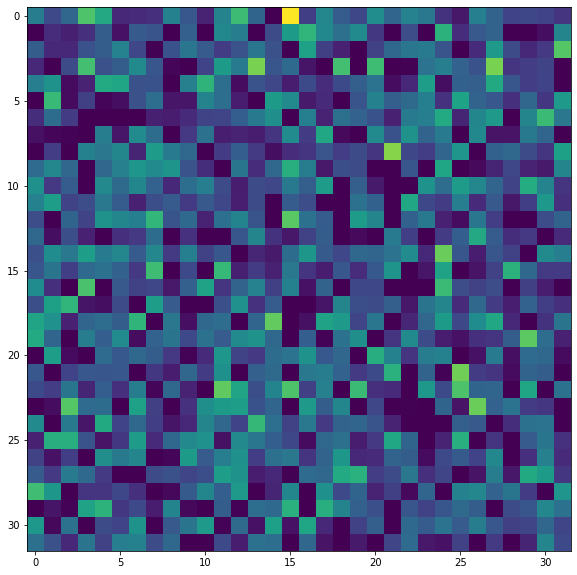

for the digit = 1 average value is = 65.42584991455078


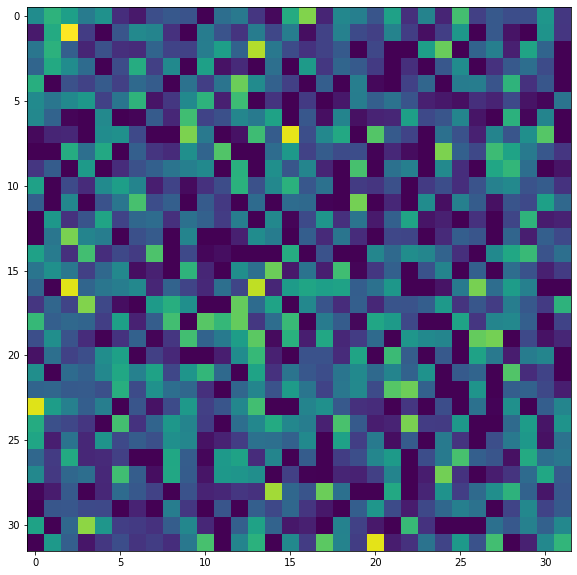

for the digit = 2 average value is = 93.7727279663086


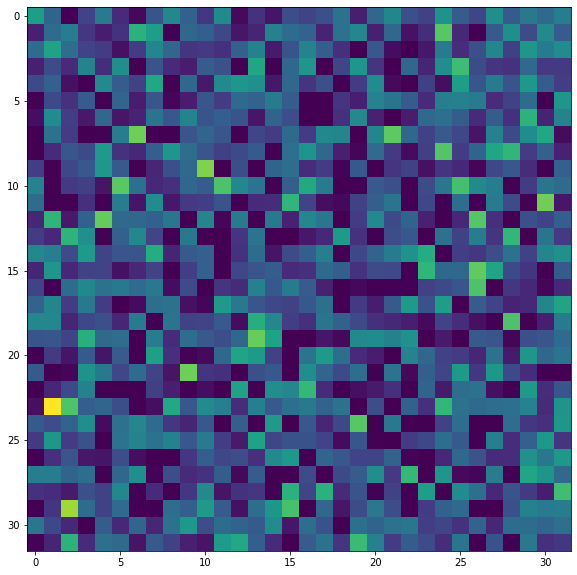

for the digit = 3 average value is = 85.11482238769531


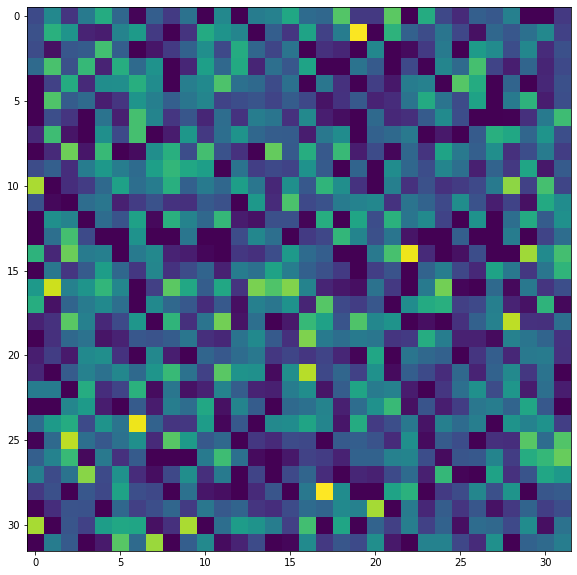

for the digit = 4 average value is = 86.35318756103516


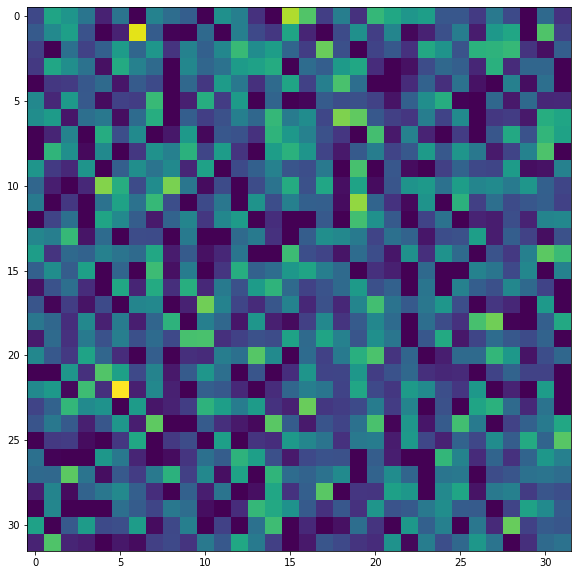

for the digit = 5 average value is = 81.92125701904297


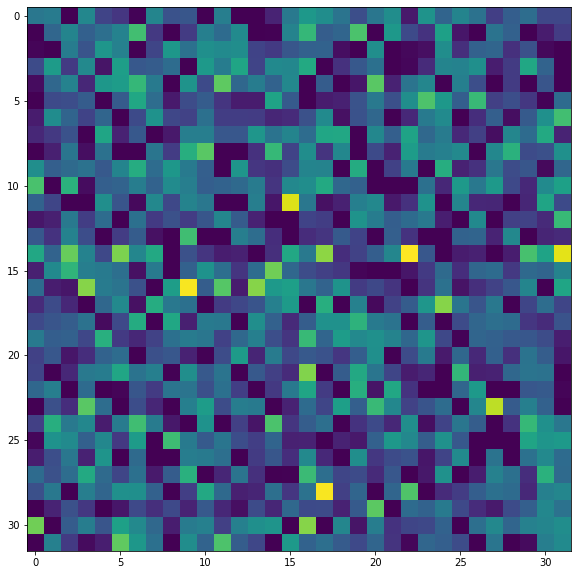

for the digit = 6 average value is = 76.35543823242188


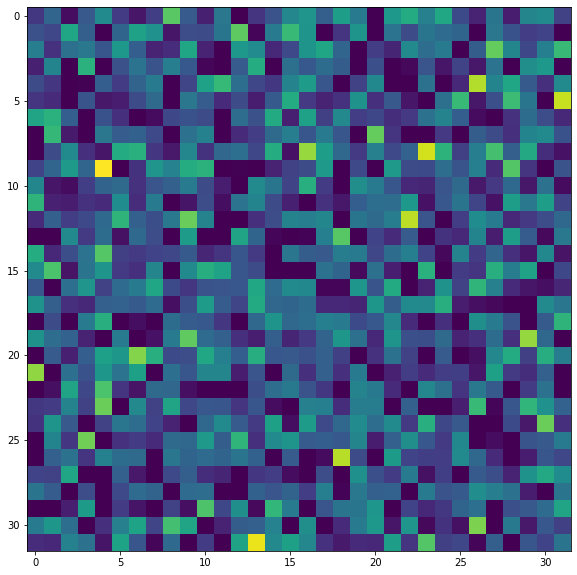

for the digit = 7 average value is = 111.32823181152344


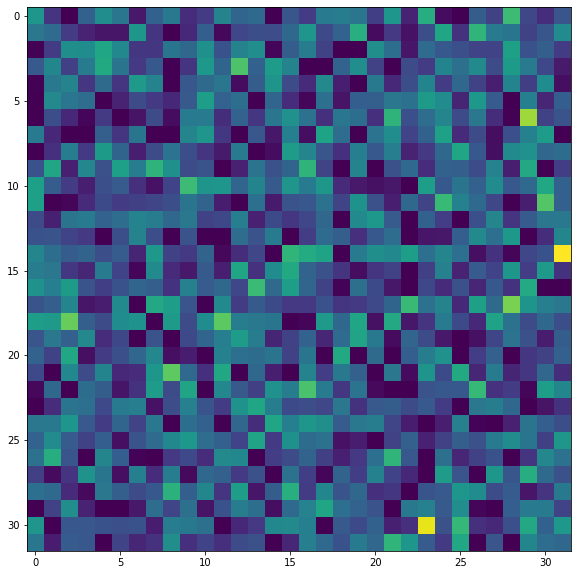

for the digit = 8 average value is = 78.93204498291016


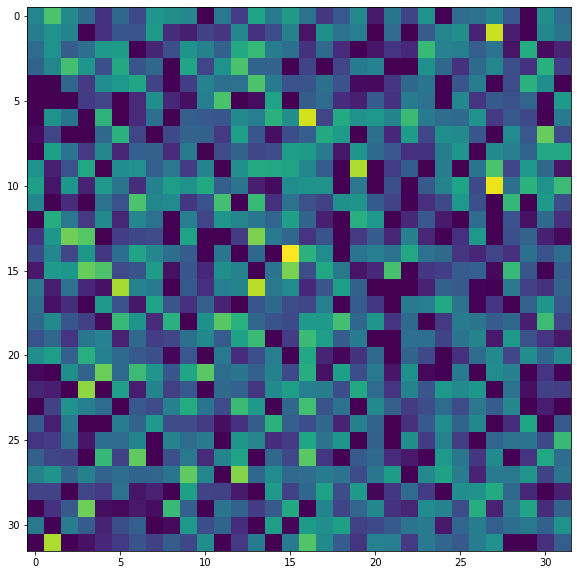

for the digit = 9 average value is = 65.29202270507812


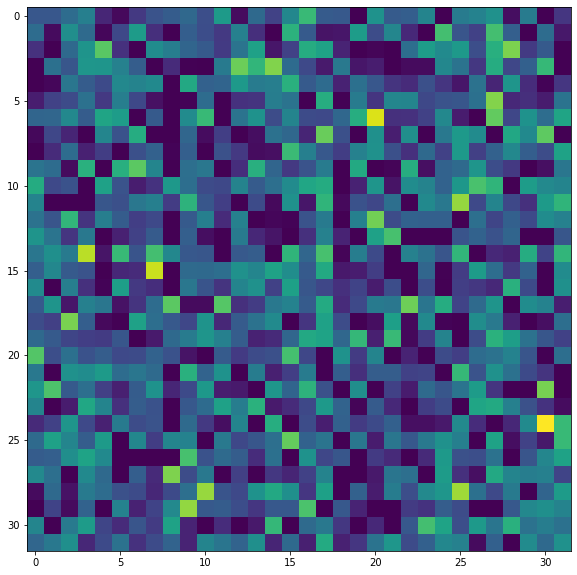

Average of these values 82.10150909423828


In [54]:
print("Average Hidden layer activations for 10 images for the hidden layer = 256")
with torch.no_grad():
  sum = 0
  for i in range(10):

    output3, encoded3=model3.forward(data[data_ind[i]].reshape(1,784).float())
    avg = torch.norm(encoded3, p=1)/1024.0
    print(f'for the digit = {i} average value is = {avg.detach().numpy()}')
    sum+=avg.detach().numpy()
    plt.imshow(encoded3.reshape(32, 32))
    plt.show()
  print("Average of these values",sum/10.0)

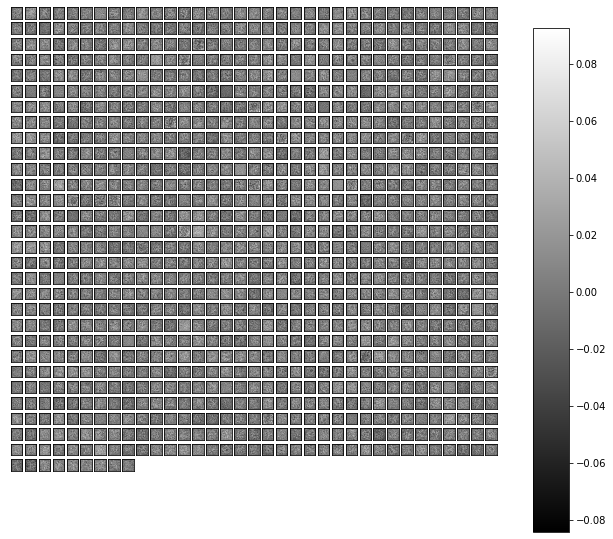

In [55]:
ix=1
fig,ax=plt.subplots()
for i in range(len(model3.state_dict()['encoder.0.weight'])):
  ax=plt.subplot(35,35,ix)
  ax.set_xticks([])
  ax.set_yticks([])
  im=ax.imshow(model3.state_dict()['encoder.0.weight'][i].reshape(28,28),cmap='gray')
  ix+=1
  
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)
plt.show()

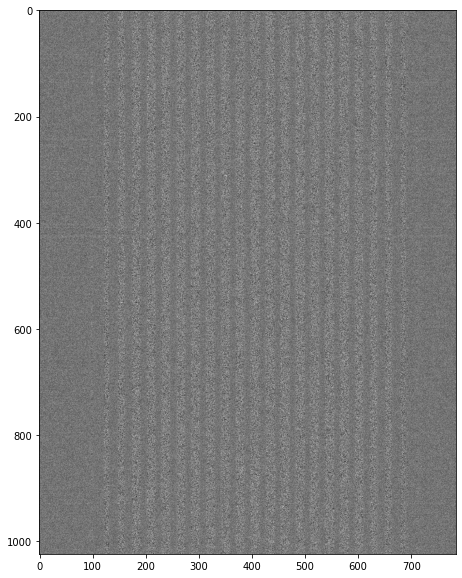

In [57]:
plt.imshow(model3.state_dict()['encoder.0.weight'],cmap='gray')


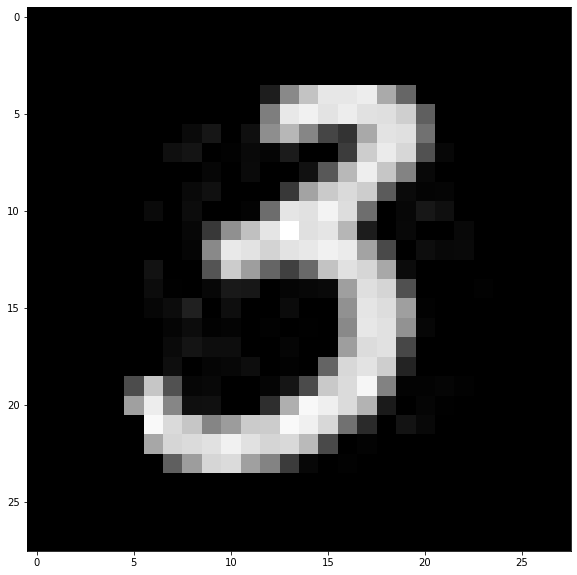

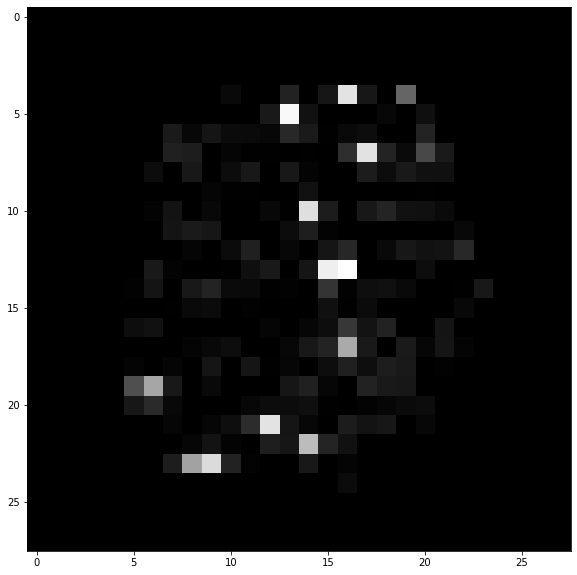

In [71]:
with torch.no_grad():
  a=random.sample(range(0,784),int(0.9*784))
  X=data[data_ind[3]].clone()
  X=X.reshape(1,784)
  X[0][a]=0
  output1=model3(data[data_ind[3]].reshape(1,784))
  plt.imshow(output1[0].reshape(28,28),cmap='gray') 
  plt.show()

  output2=model3(X.reshape(1,784))
  plt.imshow(output2[0].reshape(28,28),cmap='gray') 
  plt.show()

# **4. Denoising Encoder**

In [72]:
def Add_Noise(image, noise_val = 0.3): 
  noise = torch.randn(image.size())*noise_val
  noisy_image = image + noise
  return noisy_image

## First using autoencoder in question 2


 for noise value = 0.3

Epochs: 1/15 ||| with Training Loss = 0.25964343547821045 ||| Validation Loss = 0.2541666626930237
Epochs: 2/15 ||| with Training Loss = 0.2404690831899643 ||| Validation Loss = 0.23458996415138245
Epochs: 3/15 ||| with Training Loss = 0.2332722246646881 ||| Validation Loss = 0.2272350937128067
Epochs: 4/15 ||| with Training Loss = 0.2301328331232071 ||| Validation Loss = 0.22372418642044067
Epochs: 5/15 ||| with Training Loss = 0.2286226749420166 ||| Validation Loss = 0.22252203524112701
Epochs: 6/15 ||| with Training Loss = 0.22831477224826813 ||| Validation Loss = 0.22136977314949036
Epochs: 7/15 ||| with Training Loss = 0.22721241414546967 ||| Validation Loss = 0.2199418842792511
Epochs: 8/15 ||| with Training Loss = 0.2257051020860672 ||| Validation Loss = 0.2188408076763153
Epochs: 9/15 ||| with Training Loss = 0.22552256286144257 ||| Validation Loss = 0.2185373455286026
Epochs: 10/15 ||| with Training Loss = 0.22561019659042358 ||| Validation Loss = 0.21

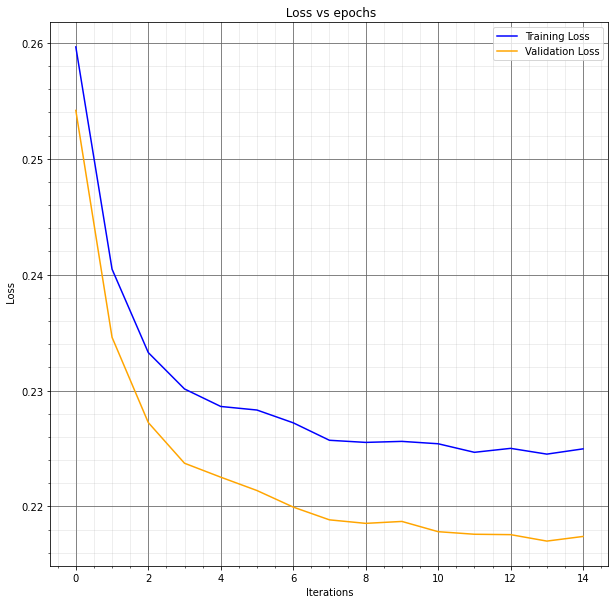

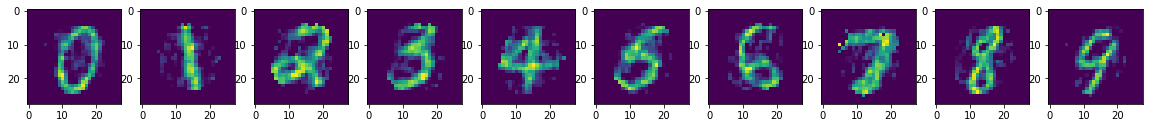


 for noise value = 0.5

Epochs: 1/15 ||| with Training Loss = 0.2878321409225464 ||| Validation Loss = 0.27613434195518494
Epochs: 2/15 ||| with Training Loss = 0.26901760697364807 ||| Validation Loss = 0.25691479444503784
Epochs: 3/15 ||| with Training Loss = 0.26329925656318665 ||| Validation Loss = 0.25007352232933044
Epochs: 4/15 ||| with Training Loss = 0.2602956295013428 ||| Validation Loss = 0.24704982340335846
Epochs: 5/15 ||| with Training Loss = 0.25883233547210693 ||| Validation Loss = 0.244818314909935
Epochs: 6/15 ||| with Training Loss = 0.25793299078941345 ||| Validation Loss = 0.24308356642723083
Epochs: 7/15 ||| with Training Loss = 0.25811874866485596 ||| Validation Loss = 0.24273598194122314
Epochs: 8/15 ||| with Training Loss = 0.25736838579177856 ||| Validation Loss = 0.24233466386795044
Epochs: 9/15 ||| with Training Loss = 0.2568536698818207 ||| Validation Loss = 0.24215535819530487
Epochs: 10/15 ||| with Training Loss = 0.2565525472164154 ||| Validation Loss = 

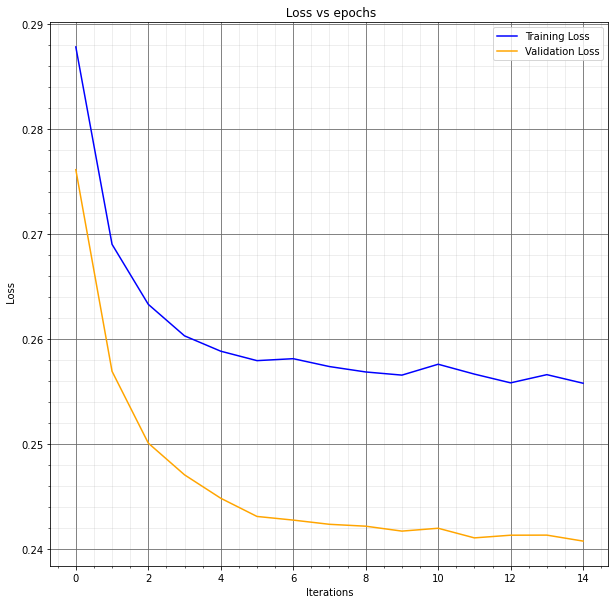

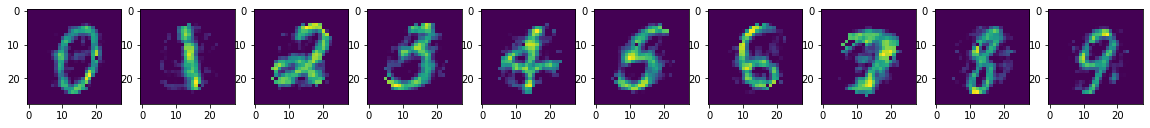


 for noise value = 0.8

Epochs: 1/15 ||| with Training Loss = 0.29636359214782715 ||| Validation Loss = 0.26738864183425903
Epochs: 2/15 ||| with Training Loss = 0.2816535234451294 ||| Validation Loss = 0.2507992386817932
Epochs: 3/15 ||| with Training Loss = 0.27668309211730957 ||| Validation Loss = 0.24541570246219635
Epochs: 4/15 ||| with Training Loss = 0.275882750749588 ||| Validation Loss = 0.24309852719306946
Epochs: 5/15 ||| with Training Loss = 0.27408668398857117 ||| Validation Loss = 0.24099692702293396
Epochs: 6/15 ||| with Training Loss = 0.2728397846221924 ||| Validation Loss = 0.2408573031425476
Epochs: 7/15 ||| with Training Loss = 0.2736726701259613 ||| Validation Loss = 0.24050545692443848
Epochs: 8/15 ||| with Training Loss = 0.2728123962879181 ||| Validation Loss = 0.23954950273036957
Epochs: 9/15 ||| with Training Loss = 0.2721427381038666 ||| Validation Loss = 0.23900291323661804
Epochs: 10/15 ||| with Training Loss = 0.27132874727249146 ||| Validation Loss = 0.2

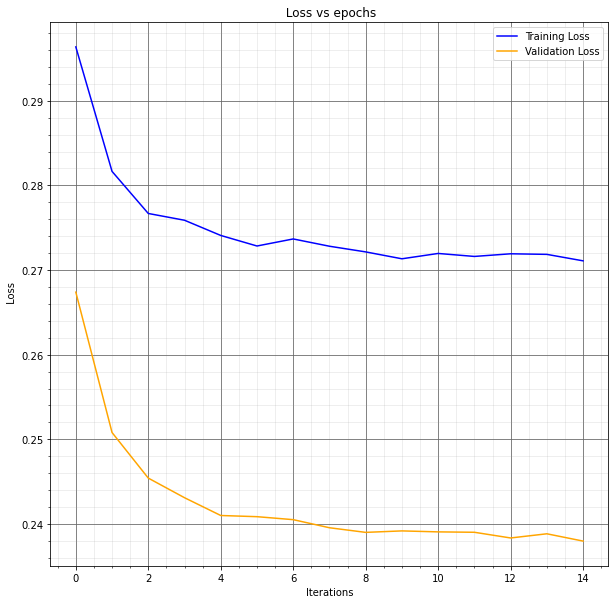

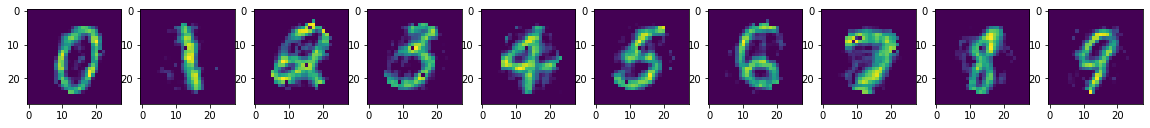


 for noise value = 0.9

Epochs: 1/15 ||| with Training Loss = 0.3061346113681793 ||| Validation Loss = 0.2713543474674225
Epochs: 2/15 ||| with Training Loss = 0.28712302446365356 ||| Validation Loss = 0.2509884238243103
Epochs: 3/15 ||| with Training Loss = 0.2818964719772339 ||| Validation Loss = 0.24540047347545624
Epochs: 4/15 ||| with Training Loss = 0.2795545160770416 ||| Validation Loss = 0.24252009391784668
Epochs: 5/15 ||| with Training Loss = 0.2771940231323242 ||| Validation Loss = 0.24065808951854706
Epochs: 6/15 ||| with Training Loss = 0.27806445956230164 ||| Validation Loss = 0.24072566628456116
Epochs: 7/15 ||| with Training Loss = 0.2770940065383911 ||| Validation Loss = 0.24046345055103302
Epochs: 8/15 ||| with Training Loss = 0.27676868438720703 ||| Validation Loss = 0.2393503040075302
Epochs: 9/15 ||| with Training Loss = 0.2761901319026947 ||| Validation Loss = 0.23872050642967224
Epochs: 10/15 ||| with Training Loss = 0.27673855423927307 ||| Validation Loss = 0.2

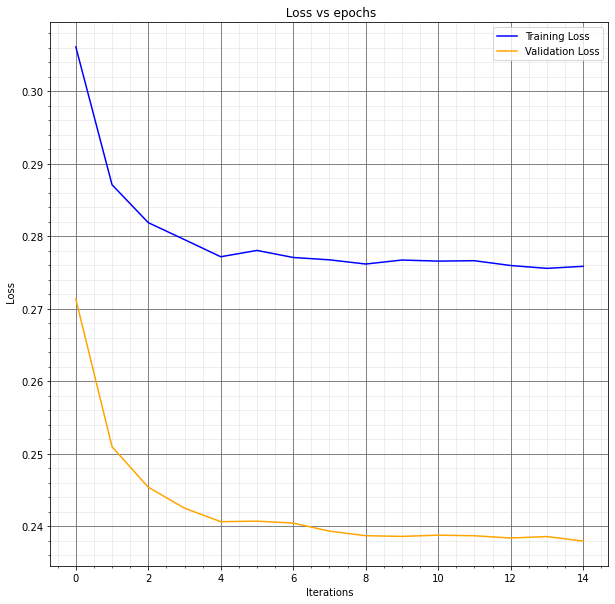

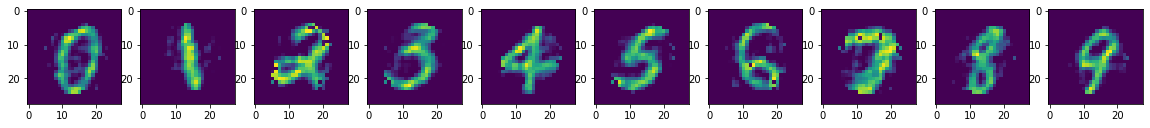

In [73]:
noise_val = [0.3, 0.5, 0.8, 0.9]
for i in range(4):
  print(f'\n for noise value = {noise_val[i]}\n')
  model4 = autoencoder_hidden(256).to(device)
  optimizer4 = optim.Adam(model4.parameters(), lr = 0.003)
  criterion = nn.MSELoss()
  training_loss, val_loss = Train(model4, optimizer4, criterion, epochs, denoise = True, noise_val = noise_val[i])
  
  visualise_loss(training_loss, val_loss)
  visualise_model(model4, data_ind, data)  

## **Observations:**
* we can observe that the training loss is minimum for the least noise value for the standard autoencoder in question 2

In [74]:
class autoencoder_denoising(nn.Module):
  def __init__(self):
    super(autoencoder_denoising, self).__init__()
    self.encoder = nn.Sequential(nn.Linear(784,64), nn.ReLU(), nn.Linear(64,8), nn.ReLU())
    self.decoder =nn.Sequential(nn.Linear(8,64), nn.ReLU(), nn.Linear(64,784), nn.ReLU())
    
  def forward(self,x):
    encoded = self.encoder(x.float())
    out = self.decoder(encoded)
    return out, encoded  


 for noise value = 0.3

Epochs: 1/15 ||| with Training Loss = 0.6848006248474121 ||| Validation Loss = 0.6831685304641724
Epochs: 2/15 ||| with Training Loss = 0.6406914591789246 ||| Validation Loss = 0.640123724937439
Epochs: 3/15 ||| with Training Loss = 0.6226150989532471 ||| Validation Loss = 0.620271623134613
Epochs: 4/15 ||| with Training Loss = 0.6120909452438354 ||| Validation Loss = 0.6102980375289917
Epochs: 5/15 ||| with Training Loss = 0.6017044186592102 ||| Validation Loss = 0.601205587387085
Epochs: 6/15 ||| with Training Loss = 0.596468985080719 ||| Validation Loss = 0.5963802337646484
Epochs: 7/15 ||| with Training Loss = 0.5918829441070557 ||| Validation Loss = 0.5904800891876221
Epochs: 8/15 ||| with Training Loss = 0.5683847069740295 ||| Validation Loss = 0.5687422156333923
Epochs: 9/15 ||| with Training Loss = 0.5593767166137695 ||| Validation Loss = 0.5602560639381409
Epochs: 10/15 ||| with Training Loss = 0.5549748539924622 ||| Validation Loss = 0.555538237094879

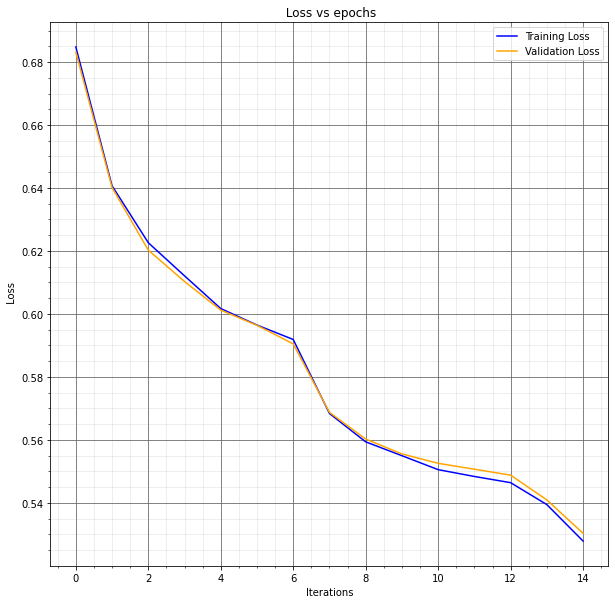

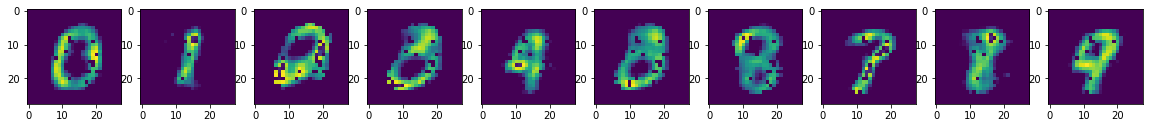


 for noise value = 0.5

Epochs: 1/15 ||| with Training Loss = 0.6872881054878235 ||| Validation Loss = 0.6823856234550476
Epochs: 2/15 ||| with Training Loss = 0.6112332344055176 ||| Validation Loss = 0.6048036217689514
Epochs: 3/15 ||| with Training Loss = 0.5865513682365417 ||| Validation Loss = 0.5807957053184509
Epochs: 4/15 ||| with Training Loss = 0.5761266350746155 ||| Validation Loss = 0.5716156959533691
Epochs: 5/15 ||| with Training Loss = 0.5708513855934143 ||| Validation Loss = 0.5662994384765625
Epochs: 6/15 ||| with Training Loss = 0.5661503672599792 ||| Validation Loss = 0.5615786910057068
Epochs: 7/15 ||| with Training Loss = 0.5633235573768616 ||| Validation Loss = 0.5578161478042603
Epochs: 8/15 ||| with Training Loss = 0.5487060546875 ||| Validation Loss = 0.5449833273887634
Epochs: 9/15 ||| with Training Loss = 0.5392489433288574 ||| Validation Loss = 0.5347309708595276
Epochs: 10/15 ||| with Training Loss = 0.5357452034950256 ||| Validation Loss = 0.53016501665115

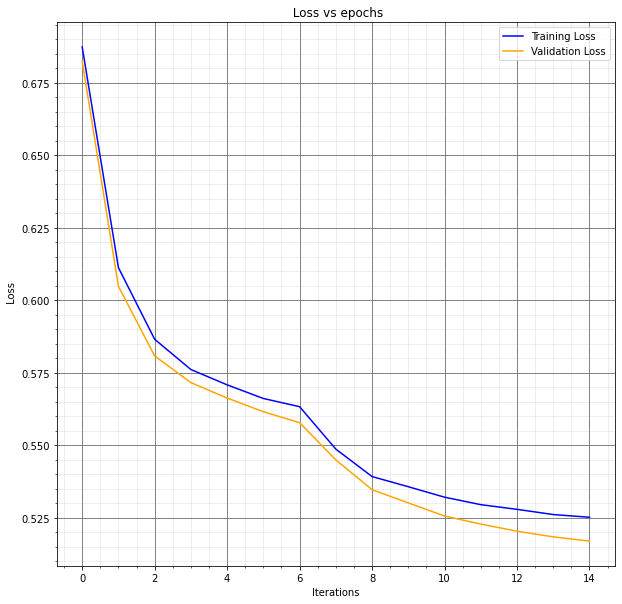

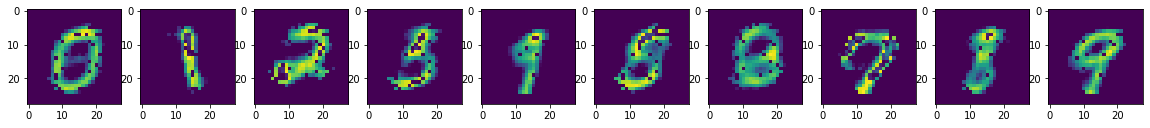


 for noise value = 0.8

Epochs: 1/15 ||| with Training Loss = 0.5721724033355713 ||| Validation Loss = 0.5582663416862488
Epochs: 2/15 ||| with Training Loss = 0.5323060154914856 ||| Validation Loss = 0.5217342972755432
Epochs: 3/15 ||| with Training Loss = 0.5184629559516907 ||| Validation Loss = 0.5045705437660217
Epochs: 4/15 ||| with Training Loss = 0.5099622011184692 ||| Validation Loss = 0.4970572292804718
Epochs: 5/15 ||| with Training Loss = 0.5041430592536926 ||| Validation Loss = 0.49176591634750366
Epochs: 6/15 ||| with Training Loss = 0.4995822310447693 ||| Validation Loss = 0.4867702126502991
Epochs: 7/15 ||| with Training Loss = 0.49537867307662964 ||| Validation Loss = 0.4835708737373352
Epochs: 8/15 ||| with Training Loss = 0.49420687556266785 ||| Validation Loss = 0.4820214807987213
Epochs: 9/15 ||| with Training Loss = 0.4906397759914398 ||| Validation Loss = 0.47901052236557007
Epochs: 10/15 ||| with Training Loss = 0.4886122941970825 ||| Validation Loss = 0.4773531

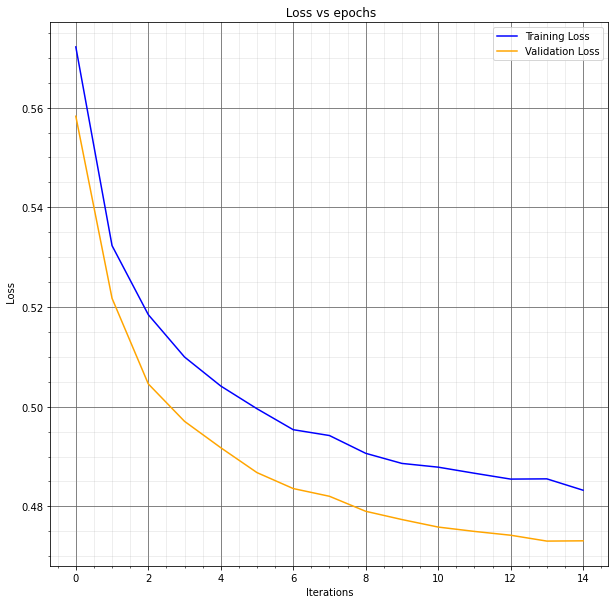

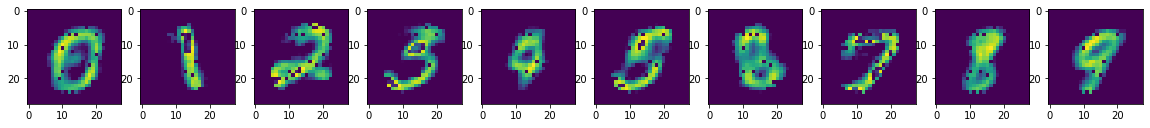


 for noise value = 0.9

Epochs: 1/15 ||| with Training Loss = 0.5881263017654419 ||| Validation Loss = 0.5775903463363647
Epochs: 2/15 ||| with Training Loss = 0.5478460192680359 ||| Validation Loss = 0.5411717295646667
Epochs: 3/15 ||| with Training Loss = 0.5340295433998108 ||| Validation Loss = 0.5279478430747986
Epochs: 4/15 ||| with Training Loss = 0.5278148651123047 ||| Validation Loss = 0.5203167200088501
Epochs: 5/15 ||| with Training Loss = 0.5223813652992249 ||| Validation Loss = 0.5154925584793091
Epochs: 6/15 ||| with Training Loss = 0.515595555305481 ||| Validation Loss = 0.508739173412323
Epochs: 7/15 ||| with Training Loss = 0.5119762420654297 ||| Validation Loss = 0.5050249695777893
Epochs: 8/15 ||| with Training Loss = 0.5084444880485535 ||| Validation Loss = 0.5034490823745728
Epochs: 9/15 ||| with Training Loss = 0.5062755346298218 ||| Validation Loss = 0.500933825969696
Epochs: 10/15 ||| with Training Loss = 0.5037600994110107 ||| Validation Loss = 0.49891370534896

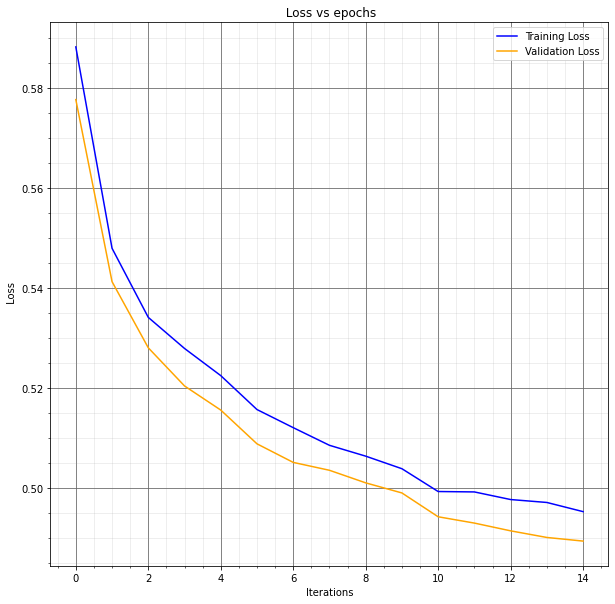

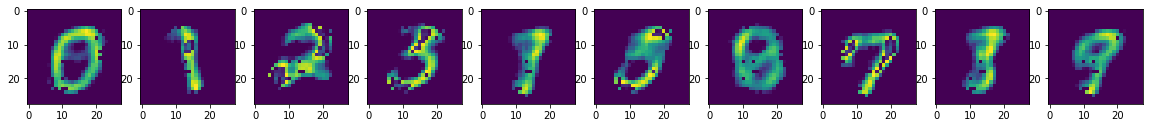

In [75]:
noise_val = [0.3, 0.5, 0.8, 0.9]
for i in range(4):
  print(f'\n for noise value = {noise_val[i]}\n')
  model5 = autoencoder_denoising().to(device)
  optimizer5 = optim.Adam(model5.parameters(), lr = 0.003)
  criterion = nn.MSELoss()
  training_loss, val_loss = Train(model5, optimizer5, criterion, epochs, denoise = True, noise_val = noise_val[i])
  
  visualise_loss(training_loss, val_loss)
  visualise_model(model5, data_ind, data)  

torch.Size([1, 8])


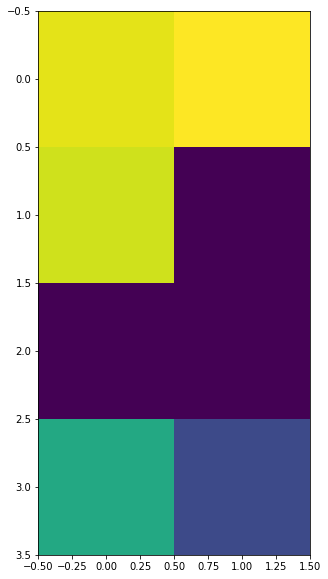

In [86]:
with torch.no_grad():
  output5, encoded5 = model5.forward(data[data_ind[3]].reshape(1,784).float())
  print(encoded5.shape)
  plt.imshow(encoded5.reshape(4, 2))

# **Convolutional Autoencoders**

**Unpooling Convolutional Autoencoder**

Encoder Module:
* **28X 28 X 1**   *to*   **14 X 14 X 8**
* **14 X 14 X 8**   *to*   **7 X 7 X 16**
* **7 X 7 X 16**   *to*   **3 X 3 X 16**

Decoder Module:
* **7 X 7 X 16** *to* **7 X 7 X 16**
* **7 X 7 X 16** *to* **14 X 14 X 8**
* **14 X 14 X 8** *to* **28 X 28 X 1**

In [76]:
class autoencoder_convolutional_unpool(nn.Module):
  def __init__(self):
    super(autoencoder_convolutional_unpool, self).__init__()
    #initializing the encoder module
    self.encoder_conv1 = nn.Sequential(
        nn.Conv2d(1,8, kernel_size = 3, stride = 1,padding= 1),nn.ReLU(),nn.MaxPool2d(kernel_size = (2,2),return_indices = True)) 
    self.encoder_conv2 = nn.Sequential(
        nn.Conv2d(8,16, kernel_size = 3, stride = 1,padding= 1),nn.ReLU(),nn.MaxPool2d(kernel_size = (2,2),return_indices = True)) 
    self.encoder_conv3 = nn.Sequential(
        nn.Conv2d(16,16, kernel_size = 3, stride = 1,padding= 1),nn.ReLU(),nn.MaxPool2d(kernel_size = (2,2),return_indices = True)) 
    
    #initializing the decoder module
    self.decoder_conv1 = nn.Sequential(
        nn.Identity()) 
    self.decoder_conv2 = nn.Sequential(
        nn.Conv2d(16,8, kernel_size = 3, stride = 1,padding= 1),nn.ReLU()) 
    self.decoder_conv3 = nn.Sequential(
        nn.Conv2d(8,1, kernel_size = 3, stride = 1,padding= 1),nn.ReLU()) 
    
    #defining the unpooling operation
    self.unpool = nn.MaxUnpool2d(kernel_size = (2,2))
        
        
  def forward(self,x): #defines the forward pass and also the structure of the network thus helping backprop
    encoded_input,indices1  = self.encoder_conv1(x.float())  
    encoded_input,indices2  = self.encoder_conv2(encoded_input) 
    encoded_input,indices3  = self.encoder_conv3(encoded_input) 
    
    
    reconstructed_input     = self.unpool(encoded_input,indices3,output_size=torch.Size([batch_size, 16, 7, 7])) 
    reconstructed_input     = self.decoder_conv1(reconstructed_input) 
    reconstructed_input     = self.unpool(reconstructed_input,indices2) 
    reconstructed_input     = self.decoder_conv2(reconstructed_input)
    reconstructed_input     = self.unpool(reconstructed_input,indices1)
    reconstructed_input     = self.decoder_conv3(reconstructed_input)

    
    return reconstructed_input,encoded_input

Epochs: 1/10 ||| with Training Loss = 0.30504223704338074 ||| Validation Loss = 0.3003740906715393
Epochs: 2/10 ||| with Training Loss = 0.26394376158714294 ||| Validation Loss = 0.2607918977737427
Epochs: 3/10 ||| with Training Loss = 0.25145184993743896 ||| Validation Loss = 0.24928033351898193
Epochs: 4/10 ||| with Training Loss = 0.23987926542758942 ||| Validation Loss = 0.23818303644657135
Epochs: 5/10 ||| with Training Loss = 0.22902315855026245 ||| Validation Loss = 0.22745725512504578
Epochs: 6/10 ||| with Training Loss = 0.21915584802627563 ||| Validation Loss = 0.21722395718097687
Epochs: 7/10 ||| with Training Loss = 0.21203015744686127 ||| Validation Loss = 0.2103302925825119
Epochs: 8/10 ||| with Training Loss = 0.2068602591753006 ||| Validation Loss = 0.20536252856254578
Epochs: 9/10 ||| with Training Loss = 0.20335638523101807 ||| Validation Loss = 0.2016081064939499
Epochs: 10/10 ||| with Training Loss = 0.2005344033241272 ||| Validation Loss = 0.19886523485183716


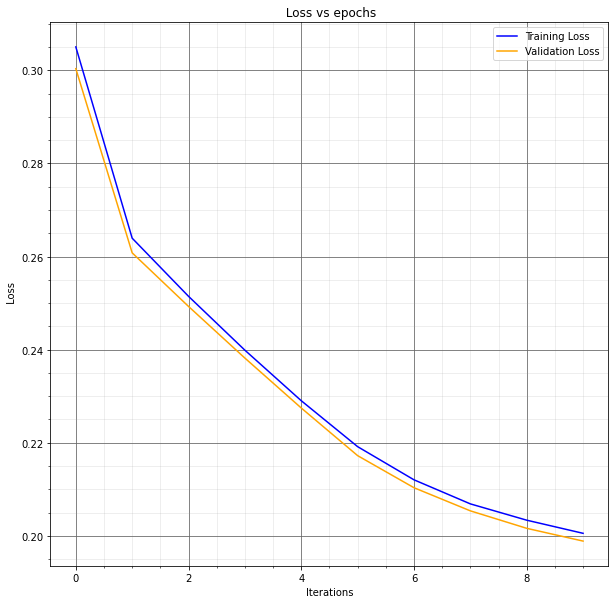

In [77]:
epochs = 10
model6 = autoencoder_convolutional_unpool().to(device)
optimizer6 = optim.Adam(model6.parameters(), lr = 0.003)
criterion = nn.MSELoss()
training_loss, val_loss = Train(model6, optimizer6, criterion, epochs, model_flag=1)
visualise_loss(training_loss, val_loss)


for digit 0
for digit 1
for digit 2
for digit 3
for digit 4
for digit 5
for digit 6
for digit 7
for digit 8
for digit 9


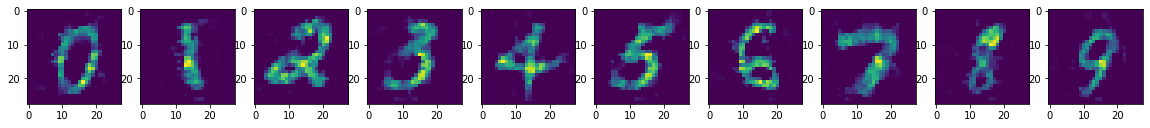

In [78]:
visualise_model(model6, data_ind, data, model_flag = 1)

**Unpooling + Deconvolution**

In [79]:
class autoencoder_deconv_unpool(nn.Module):
  def __init__(self): 
    super(autoencoder_deconv_unpool,self).__init__() 
    
      #initializing the encoder module
    self.encoder_conv1 = nn.Sequential(
        nn.Conv2d(1,8, kernel_size = 3, stride = 1,padding= 1),nn.ReLU(),nn.MaxPool2d(kernel_size = (2,2),return_indices = True))
    self.encoder_conv2 = nn.Sequential(
        nn.Conv2d(8,16, kernel_size = 3, stride = 1,padding= 1),nn.ReLU(),nn.MaxPool2d(kernel_size = (2,2),return_indices = True))
    self.encoder_conv3 = nn.Sequential(
        nn.Conv2d(16,16, kernel_size = 3, stride = 1,padding= 1),nn.ReLU(),nn.MaxPool2d(kernel_size = (2,2),return_indices = True))
    
    #initializing the decoder module
    self.decoder_conv1 = nn.Sequential(
        nn.ConvTranspose2d(16,16, kernel_size = 3, stride = 1, padding = 1),nn.ReLU())
    self.decoder_conv2 = nn.Sequential(
        nn.ConvTranspose2d(16,8, kernel_size = 3, stride = 1, padding = 1),nn.ReLU())
    self.decoder_conv3 = nn.Sequential(
        nn.ConvTranspose2d(8,1, kernel_size = 3, stride = 1, padding = 1),nn.ReLU())
    
    #defining the unpooling operation
    self.unpool = nn.MaxUnpool2d(kernel_size = (2,2))
        
  def forward(self,x):

    encoded_input,indices1  = self.encoder_conv1(x.float())
    encoded_input,indices2  = self.encoder_conv2(encoded_input)
    encoded_input,indices3  = self.encoder_conv3(encoded_input)
    
    
    reconstructed_input     = self.unpool(encoded_input,indices3,output_size=torch.Size([batch_size, 16, 7, 7]))
    reconstructed_input     = self.decoder_conv1(reconstructed_input)
    reconstructed_input     = self.unpool(reconstructed_input,indices2)
    reconstructed_input     = self.decoder_conv2(reconstructed_input)
    reconstructed_input     = self.unpool(reconstructed_input,indices1)
    reconstructed_input     = self.decoder_conv3(reconstructed_input)
    
    return reconstructed_input,encoded_input    


Epochs: 1/10 ||| with Training Loss = 0.25539734959602356 ||| Validation Loss = 0.2514868378639221
Epochs: 2/10 ||| with Training Loss = 0.2148585319519043 ||| Validation Loss = 0.2131403684616089
Epochs: 3/10 ||| with Training Loss = 0.2032325565814972 ||| Validation Loss = 0.20196329057216644
Epochs: 4/10 ||| with Training Loss = 0.1985708326101303 ||| Validation Loss = 0.19741162657737732
Epochs: 5/10 ||| with Training Loss = 0.1945735067129135 ||| Validation Loss = 0.19352756440639496
Epochs: 6/10 ||| with Training Loss = 0.1902538686990738 ||| Validation Loss = 0.18954743444919586
Epochs: 7/10 ||| with Training Loss = 0.1876154989004135 ||| Validation Loss = 0.18679484724998474
Epochs: 8/10 ||| with Training Loss = 0.18576161563396454 ||| Validation Loss = 0.18499350547790527
Epochs: 9/10 ||| with Training Loss = 0.18407995998859406 ||| Validation Loss = 0.18318553268909454
Epochs: 10/10 ||| with Training Loss = 0.18284496665000916 ||| Validation Loss = 0.18181955814361572


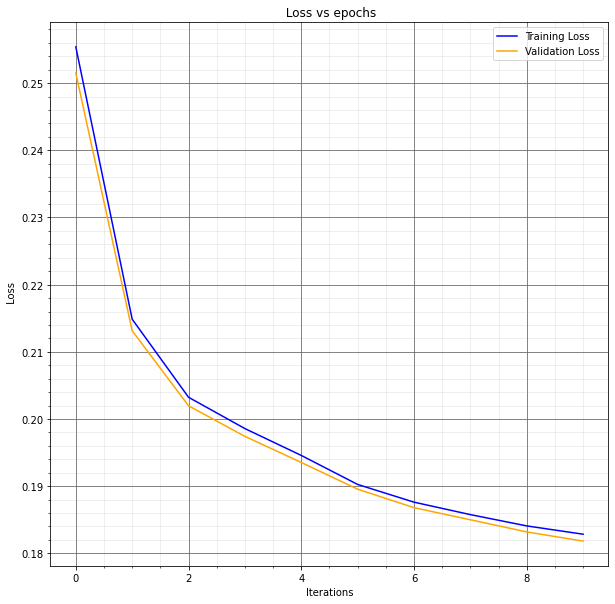

In [80]:
epochs = 10
model8 = autoencoder_deconv_unpool().to(device)
optimizer8 = optim.Adam(model8.parameters(), lr = 0.003)
criterion = nn.MSELoss()
training_loss, val_loss = Train(model8, optimizer8, criterion, epochs, model_flag=1)
visualise_loss(training_loss, val_loss)


for digit 0
for digit 1
for digit 2
for digit 3
for digit 4
for digit 5
for digit 6
for digit 7
for digit 8
for digit 9


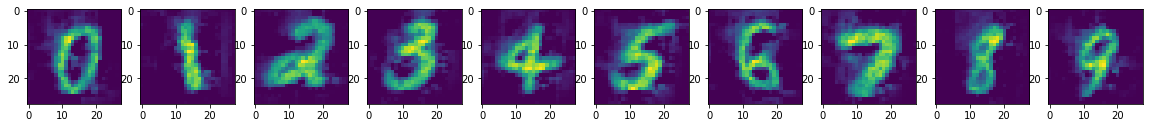

In [81]:
visualise_model(model8, data_ind, data, model_flag = 1)

**Deconvolution**

In [82]:
class autoencoder_conv_deconv(nn.Module):
  def __init__(self): 
    super(autoencoder_conv_deconv,self).__init__()
    
    #initializing the encoder module
    self.encoder_conv1 = nn.Sequential(
        nn.Conv2d(1,8, kernel_size = 3, stride = 1,padding= 1),nn.ReLU(),nn.MaxPool2d(kernel_size = (2,2)))
    self.encoder_conv2 = nn.Sequential(
        nn.Conv2d(8,16, kernel_size = 3, stride = 1,padding= 1),nn.ReLU(),nn.MaxPool2d(kernel_size = (2,2)))
    self.encoder_conv3 = nn.Sequential(
        nn.Conv2d(16,16, kernel_size = 3, stride = 1,padding= 1),nn.ReLU(),nn.MaxPool2d(kernel_size = (2,2)))
    
    #initializing the decoder module
    self.decoder_conv1 = nn.Sequential(
        nn.ConvTranspose2d(16,16, kernel_size = 3, stride = 2),nn.ReLU())
    self.decoder_conv2 = nn.Sequential(
        nn.ConvTranspose2d(16,8, kernel_size = 4, stride = 2, padding = 1),nn.ReLU())
    self.decoder_conv3 = nn.Sequential(
        nn.ConvTranspose2d(8,1, kernel_size = 4, stride = 2, padding = 1),nn.ReLU())
    
  def forward(self,x): 

    encoded_input  = self.encoder_conv1(x.float())
    encoded_input  = self.encoder_conv2(encoded_input)
    encoded_input  = self.encoder_conv3(encoded_input)

    reconstructed_input     = self.decoder_conv1(encoded_input)
    reconstructed_input     = self.decoder_conv2(reconstructed_input)
    reconstructed_input     = self.decoder_conv3(reconstructed_input)

    return reconstructed_input,encoded_input


Epochs: 1/10 ||| with Training Loss = 0.42669978737831116 ||| Validation Loss = 0.41601505875587463
Epochs: 2/10 ||| with Training Loss = 0.34065744280815125 ||| Validation Loss = 0.3357812762260437
Epochs: 3/10 ||| with Training Loss = 0.30736157298088074 ||| Validation Loss = 0.3067431151866913
Epochs: 4/10 ||| with Training Loss = 0.28730306029319763 ||| Validation Loss = 0.28645655512809753
Epochs: 5/10 ||| with Training Loss = 0.27460142970085144 ||| Validation Loss = 0.2739414572715759
Epochs: 6/10 ||| with Training Loss = 0.2669924795627594 ||| Validation Loss = 0.266570508480072
Epochs: 7/10 ||| with Training Loss = 0.260661780834198 ||| Validation Loss = 0.25891631841659546
Epochs: 8/10 ||| with Training Loss = 0.25803104043006897 ||| Validation Loss = 0.25548702478408813
Epochs: 9/10 ||| with Training Loss = 0.2523624002933502 ||| Validation Loss = 0.25267475843429565
Epochs: 10/10 ||| with Training Loss = 0.24958175420761108 ||| Validation Loss = 0.24853822588920593


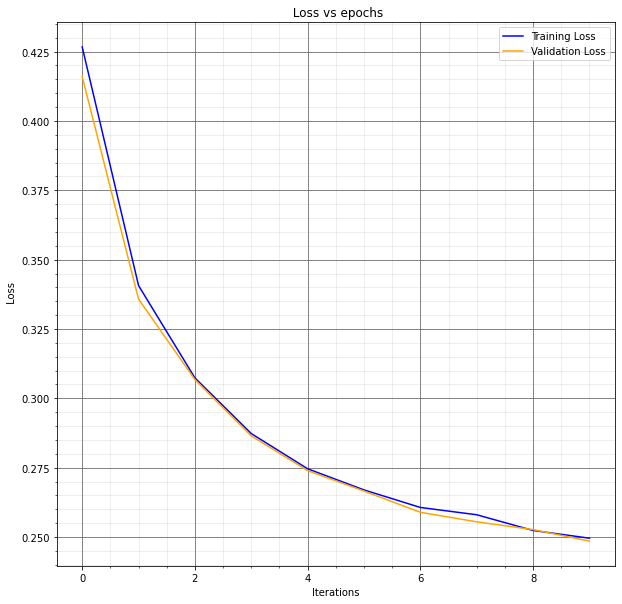

In [83]:
epochs = 10
model7 = autoencoder_conv_deconv().to(device)
optimizer7 = optim.Adam(model7.parameters(), lr = 0.003)
criterion = nn.MSELoss()
training_loss, val_loss = Train(model7, optimizer7, criterion, epochs, model_flag=1)
visualise_loss(training_loss, val_loss)


for digit 0
for digit 1
for digit 2
for digit 3
for digit 4
for digit 5
for digit 6
for digit 7
for digit 8
for digit 9


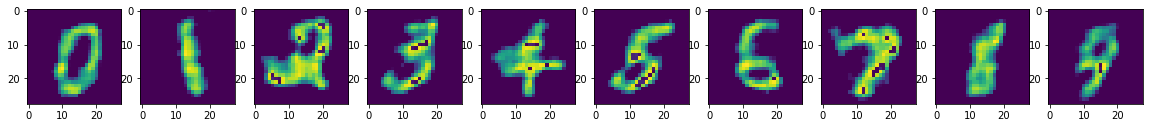

In [84]:
visualise_model(model7, data_ind, data, model_flag = 1)

## **Observations:**

* We observe that for unpooling + deconvolution we get the best output for convolutional autoencoders , suceeded by unpooling and deconvolution.

* Convolutional autoencoders take more time to run though, as compared to the standard autoencoders